# 07 - Pair Plots & PairGrid in Seaborn

## Goal
Use Seaborn's grid plots for fast multivariate EDA:
- `pairplot()` for quick exploration of many numeric variables.
- Customizing diagonals (hist/KDE) and off-diagonals (scatter/KDE).
- `PairGrid` for full control using `g.map_upper()`, `g.map_lower()`, `g.map_diag()`.
- `hue` mapping for class separation.

## Why this matters (industry-standard EDA)
In real projects (finance risk, churn prediction, manufacturing quality, e-commerce analytics), pair grids are a standard first-pass tool to:
- detect **collinearity** (redundant features)
- spot **non-linear relationships**
- see **class separation** (e.g., churn vs non-churn)
- identify **outliers** and **distribution shifts**

## Quick cheat sheet
| Tool | Best for | Common params |
|---|---|---|
| `sns.pairplot()` | One-liner EDA for a whole dataset | `hue`, `vars`, `corner`, `kind`, `diag_kind`, `plot_kws`, `diag_kws` |
| `sns.PairGrid()` | Fully customized grid | `g.map_upper`, `g.map_lower`, `g.map_diag`, `hue`, `palette` |

## Practical tips
- Use `corner=True` to reduce duplicate plots and speed up.
- For large datasets, sample rows (`df.sample(n=..., random_state=...)`).
- Keep only the most relevant numeric columns (4–8) for readability.
- Prefer transparency: `plot_kws={'alpha':0.3, 's':15}`.


In [1]:
# Setup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', context='notebook')
np.random.seed(42)


## 0) Real-world example: Telecom / SaaS churn (synthetic)
A very common industry task is churn prediction.

### Typical features
- `tenure_months`: how long the customer stayed
- `monthly_charges`: recurring amount
- `support_tickets_90d`: friction / support load
- `usage_gb`: product usage
- `late_payments_12m`: payment behavior
- Target: `churn` (0/1)

We create a synthetic dataset with realistic relationships:
- Higher monthly charges + more tickets + more late payments → higher churn probability
- Higher tenure and usage → lower churn probability


In [2]:
# Synthetic churn dataset
n = 1200

tenure_months = np.random.gamma(shape=2.0, scale=10.0, size=n).clip(1, 72)
monthly_charges = np.random.normal(loc=55, scale=18, size=n).clip(10, 140)
usage_gb = np.random.lognormal(mean=2.4, sigma=0.6, size=n)  # skewed
support_tickets_90d = np.random.poisson(lam=1.2, size=n)
late_payments_12m = np.random.poisson(lam=0.5, size=n)

# Channel/segment-like categorical variable (common in industry)
segment = np.random.choice(['SMB', 'Mid-Market', 'Enterprise'], size=n, p=[0.55, 0.30, 0.15])
seg_bias = pd.Series(segment).map({'SMB': 0.15, 'Mid-Market': 0.05, 'Enterprise': -0.10}).to_numpy()

# Logistic churn probability
logits = (
    -1.3
    - 0.020 * tenure_months
    - 0.080 * np.log1p(usage_gb)
    + 0.018 * monthly_charges
    + 0.35 * support_tickets_90d
    + 0.45 * late_payments_12m
    + seg_bias
)

p_churn = 1 / (1 + np.exp(-logits))
churn = (np.random.rand(n) < p_churn).astype(int)

churn_df = pd.DataFrame({
    'tenure_months': tenure_months,
    'monthly_charges': monthly_charges,
    'usage_gb': usage_gb,
    'support_tickets_90d': support_tickets_90d,
    'late_payments_12m': late_payments_12m,
    'segment': segment,
    'churn': churn
})

churn_df.head()


,tenure_months,monthly_charges,usage_gb,support_tickets_90d,late_payments_12m,segment,churn
0,23.936794,78.069588,14.510911,1,0,SMB,1
1,14.944647,65.038439,6.123705,1,2,SMB,1
2,13.822836,34.993757,5.517918,1,0,Mid-Market,0
3,13.823023,59.437086,4.005199,0,0,Mid-Market,1
4,46.497144,63.967991,3.757164,1,1,SMB,1


In [3]:
print(churn_df.shape)
print('Churn rate:', churn_df['churn'].mean().round(3))


(1200, 7)
Churn rate: 0.462


## 1) Pairplot (`pairplot`) for quick exploration
`pairplot()` quickly creates:
- off-diagonal: relationships between pairs of numeric variables
- diagonal: univariate distribution for each numeric variable

### Industry standard usage
- Pick 4–6 numeric variables.
- Use `hue` to see whether the target class separates.
- Use `corner=True` to avoid duplicate mirrored plots.


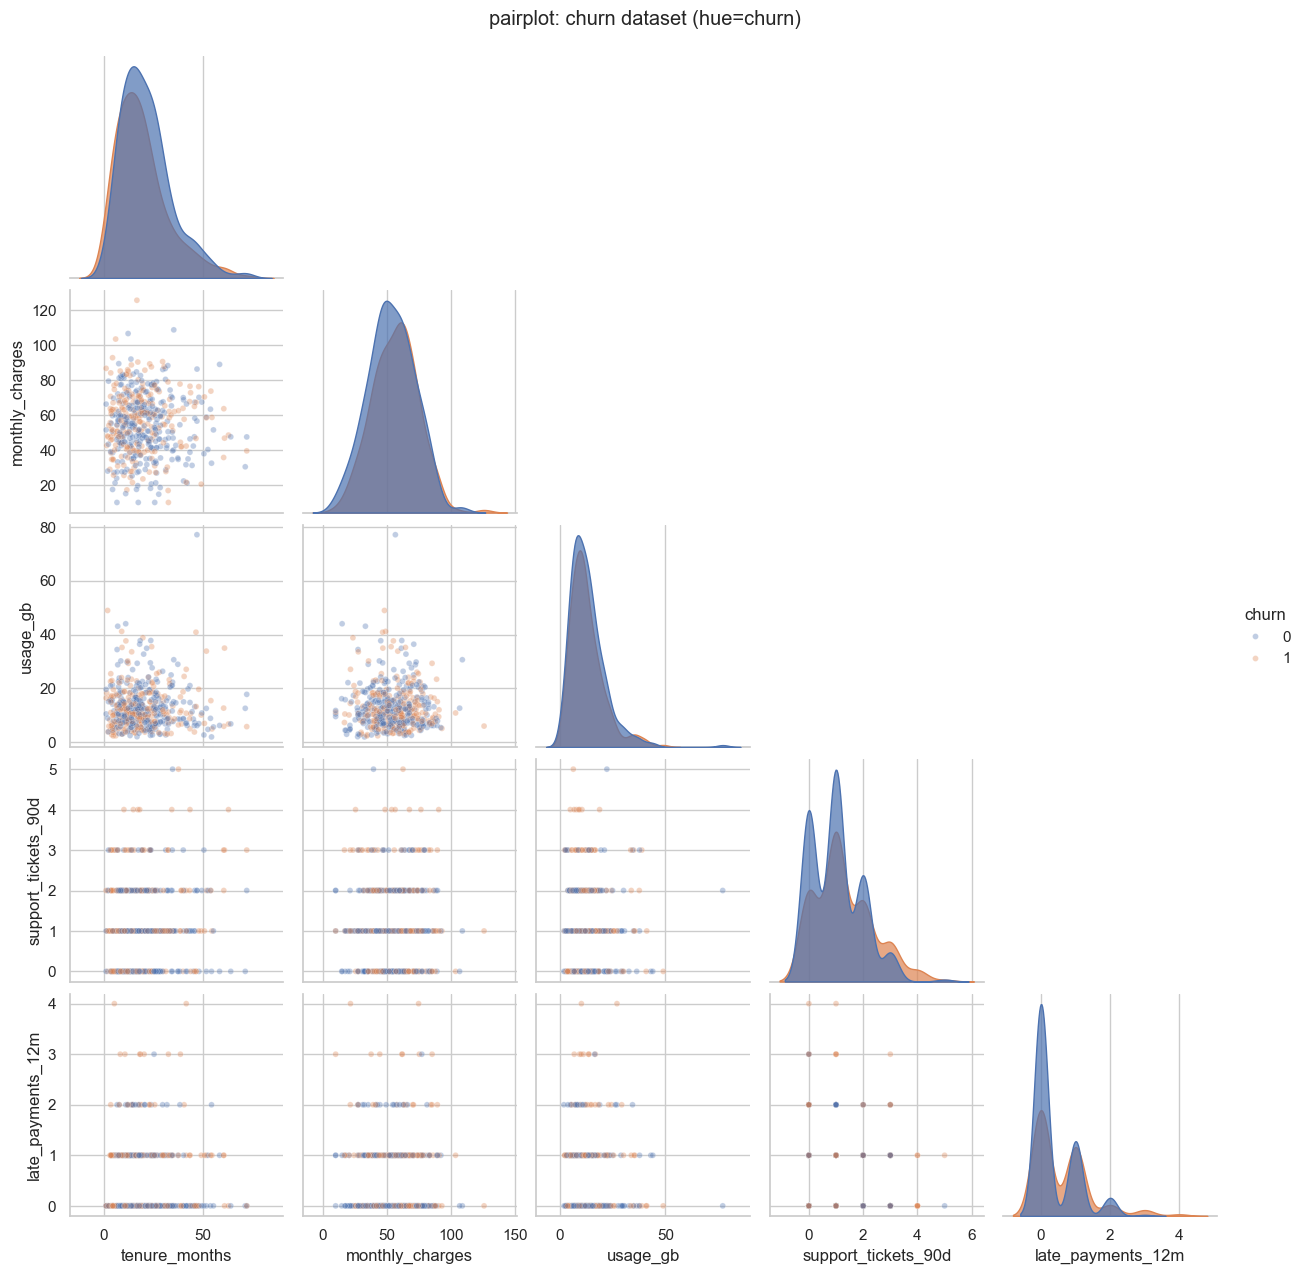

In [4]:
# Keep a manageable subset of variables
vars_ = ['tenure_months', 'monthly_charges', 'usage_gb', 'support_tickets_90d', 'late_payments_12m']

# Optionally sample for speed when n is large
sample = churn_df.sample(n=500, random_state=42)

sns.pairplot(
    data=sample,
    vars=vars_,
    hue='churn',
    corner=True,
    plot_kws={'alpha': 0.35, 's': 18},
    diag_kws={'alpha': 0.7}
)
plt.suptitle('pairplot: churn dataset (hue=churn)', y=1.02)
plt.show()


## 2) Customizing diagonals
`pairplot()` supports `diag_kind`:
- `diag_kind='hist'` (fast, clear)
- `diag_kind='kde'` (smooth density; can be slower)

Off-diagonal `kind`:
- `kind='scatter'` (default)
- `kind='kde'` (density contours; helpful when many points overlap)

Tip: With binary `hue`, KDE diagonals can be very informative for class separation.


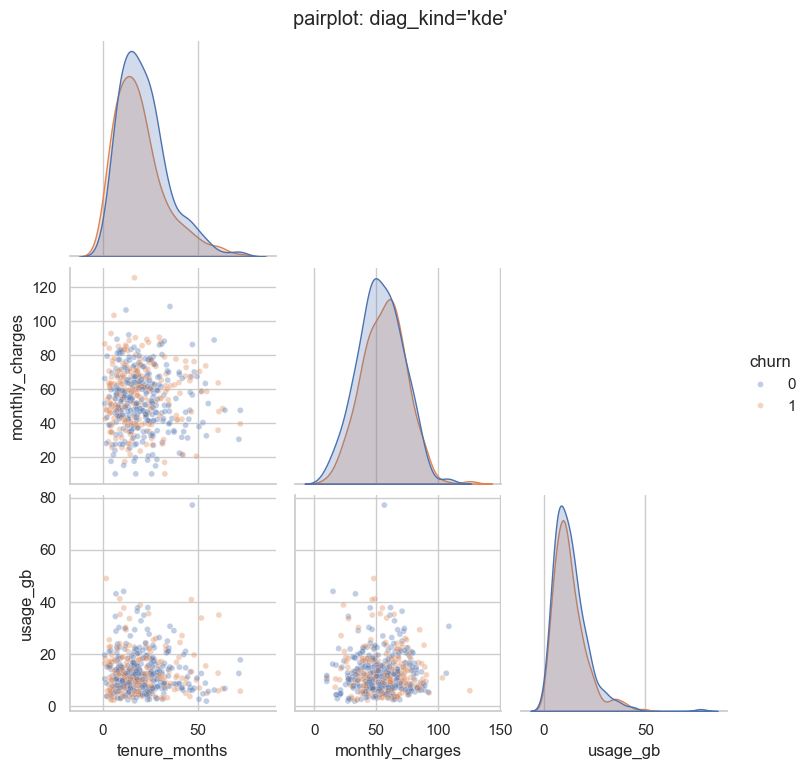

In [5]:
# Diagonal KDE (class separation), scatter off-diagonal
sns.pairplot(
    data=sample,
    vars=['tenure_months', 'monthly_charges', 'usage_gb'],
    hue='churn',
    corner=True,
    diag_kind='kde',
    plot_kws={'alpha': 0.35, 's': 18},
)
plt.suptitle("pairplot: diag_kind='kde'", y=1.02)
plt.show()


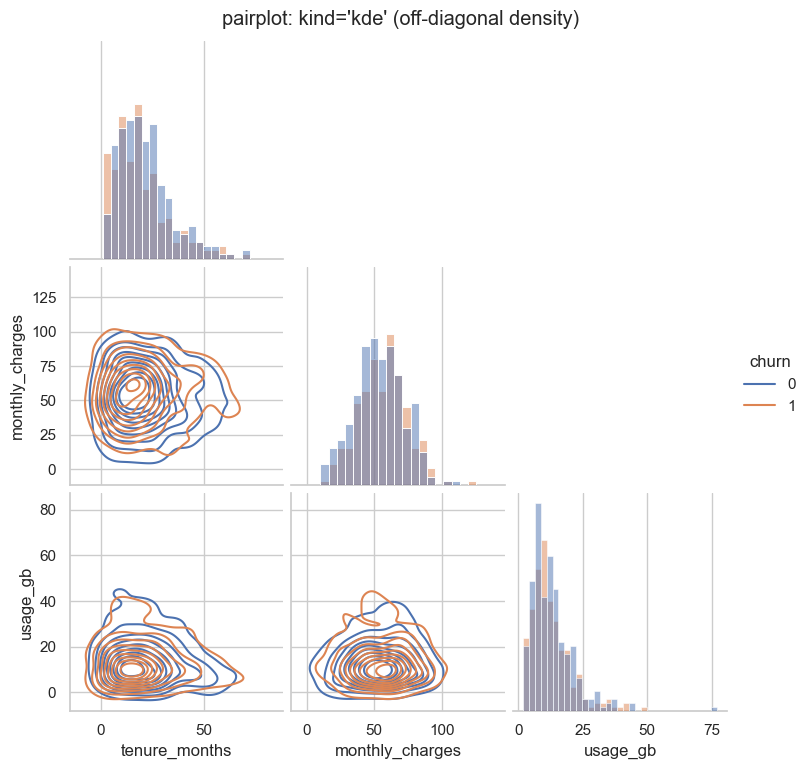

In [6]:
# Off-diagonal KDE (contours) can be better for dense data
sns.pairplot(
    data=sample,
    vars=['tenure_months', 'monthly_charges', 'usage_gb'],
    hue='churn',
    corner=True,
    kind='kde',
    diag_kind='hist',
)
plt.suptitle("pairplot: kind='kde' (off-diagonal density)", y=1.02)
plt.show()


## 3) PairGrid for full customization
`PairGrid` is used when:
- You want different plot types on upper vs lower triangles
- You want special diagonal plots
- You need custom functions for mapping

### Core API
- `g = sns.PairGrid(df, vars=[...], hue='class')`
- `g.map_upper(func)`
- `g.map_lower(func)`
- `g.map_diag(func)`
- `g.add_legend()`


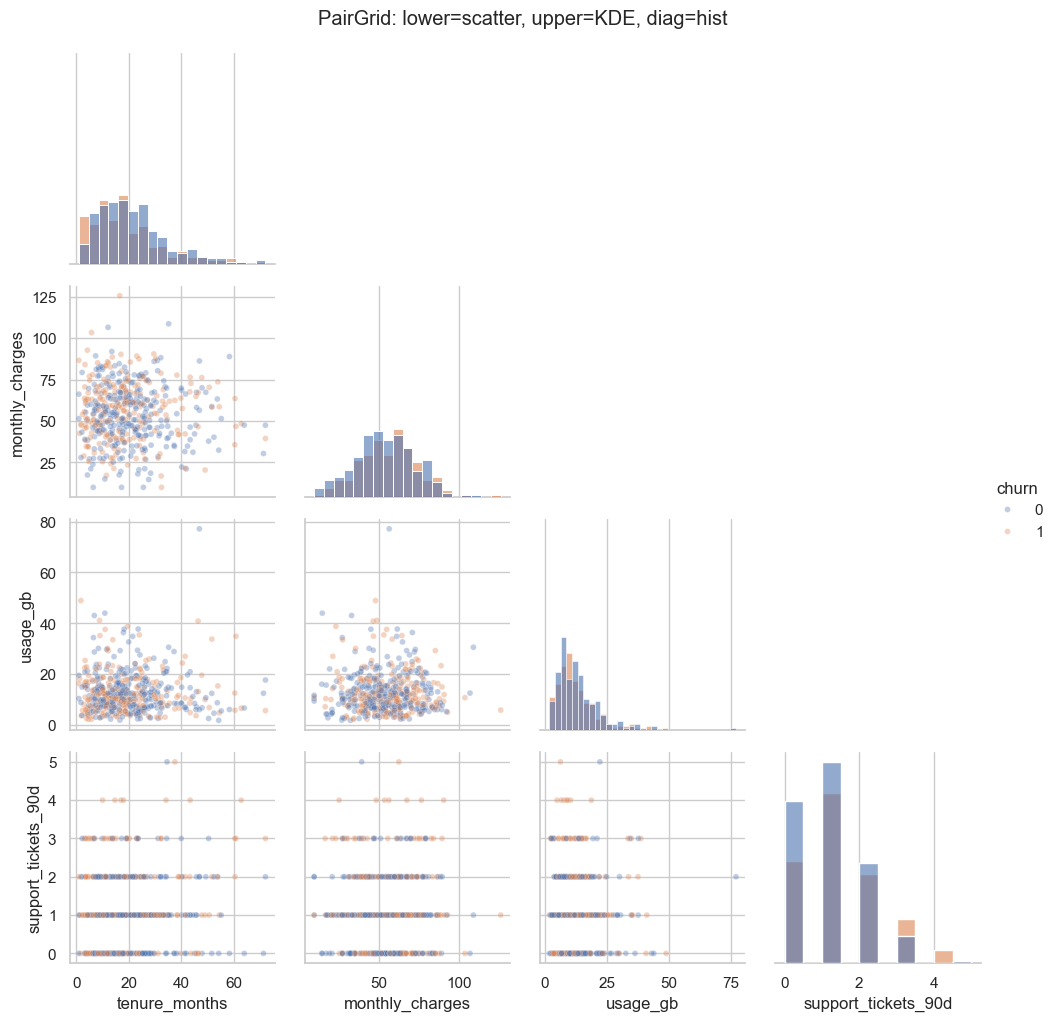

In [7]:
# PairGrid: upper=KDE contours, lower=scatter, diag=hist
small = sample[['tenure_months', 'monthly_charges', 'usage_gb', 'support_tickets_90d', 'churn']]

g = sns.PairGrid(
    data=small,
    vars=['tenure_months', 'monthly_charges', 'usage_gb', 'support_tickets_90d'],
    hue='churn',
    corner=True
)

g.map_lower(sns.scatterplot, alpha=0.35, s=18)
g.map_upper(sns.kdeplot, fill=False, levels=6, thresh=0.10)
g.map_diag(sns.histplot, alpha=0.6, bins='auto')

g.add_legend(title='churn')
g.fig.suptitle('PairGrid: lower=scatter, upper=KDE, diag=hist', y=1.02)
plt.show()


### Advanced customization idea (industry)
A common pattern is to add trend lines (regression) on one triangle and raw scatter on the other.
This is useful when presenting to stakeholders: it shows both raw evidence and a simplified trend.


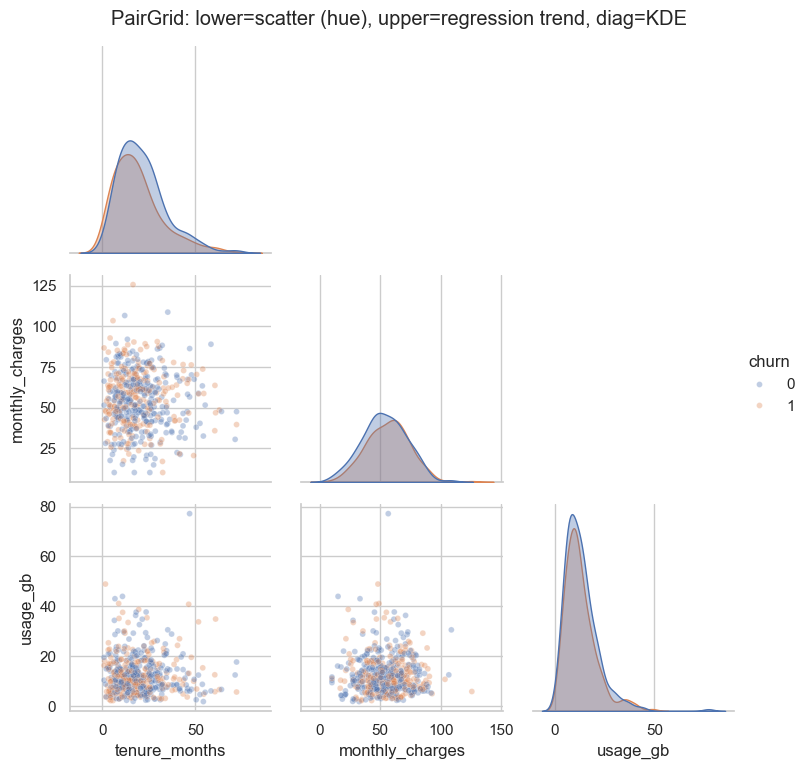

In [8]:
# PairGrid: lower=scatter, upper=regression, diag=KDE
small2 = sample[['tenure_months', 'monthly_charges', 'usage_gb', 'churn']]

g = sns.PairGrid(
    data=small2,
    vars=['tenure_months', 'monthly_charges', 'usage_gb'],
    hue='churn',
    corner=True
)

g.map_lower(sns.scatterplot, alpha=0.35, s=18)

# regplot doesn't accept hue directly when mapped this way, so we map without hue on upper triangle
# and rely on the lower triangle to show class separation.
g.map_upper(sns.regplot, scatter=False, ci=None, line_kws={'color': 'black'})

g.map_diag(sns.kdeplot, fill=True, alpha=0.35)

g.add_legend(title='churn')
g.fig.suptitle('PairGrid: lower=scatter (hue), upper=regression trend, diag=KDE', y=1.02)
plt.show()


## 4) Real-world dataset: `penguins` (Seaborn)
The `penguins` dataset is widely used for multivariate EDA demonstrations.

Industry analogy:
- Think of `species` as a **class label**.
- Numeric measurements behave like sensor features in manufacturing/IoT.

We use it to demonstrate `hue` separation and clean pairplots.


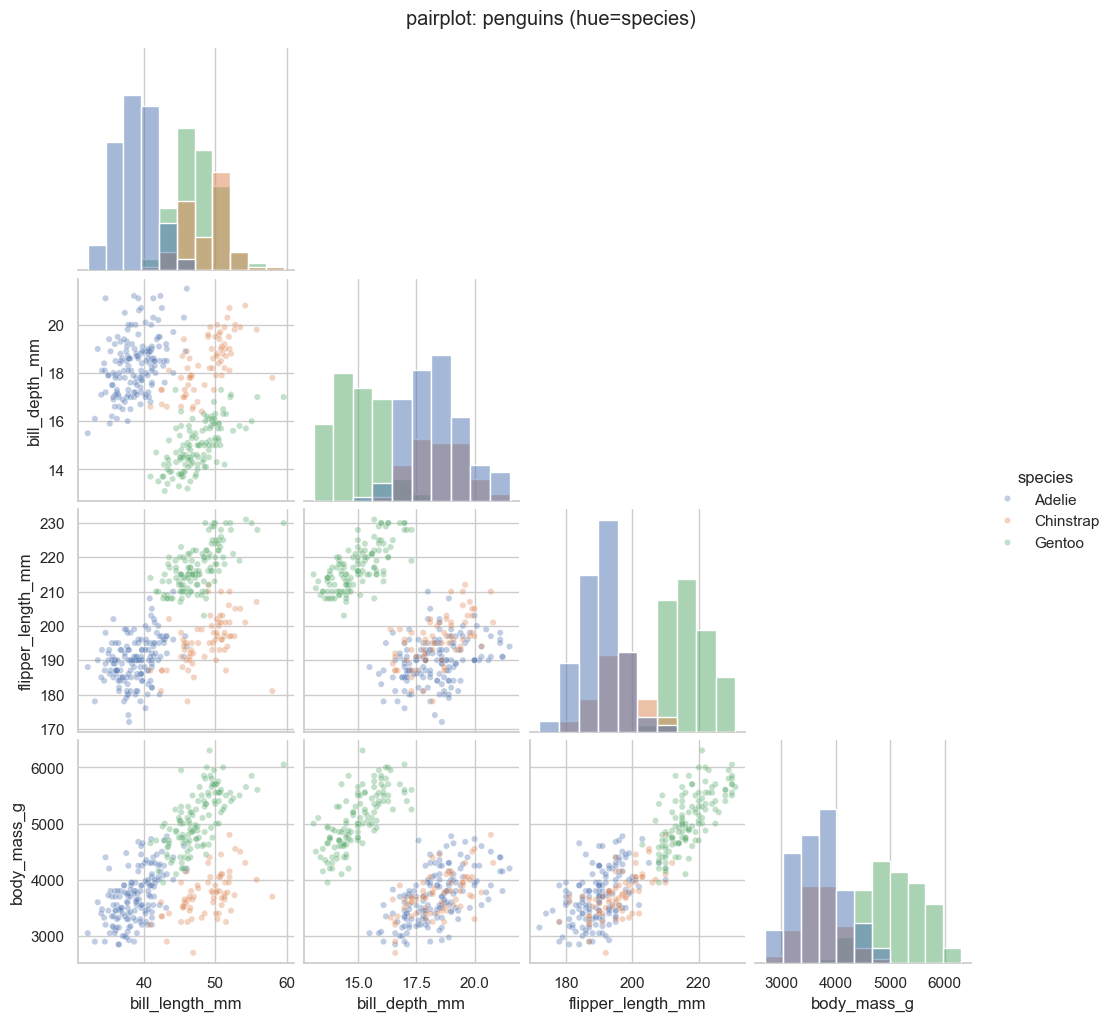

In [9]:
# Penguins dataset (real)
penguins = sns.load_dataset('penguins').dropna(subset=['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','species'])

sns.pairplot(
    data=penguins,
    vars=['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g'],
    hue='species',
    corner=True,
    diag_kind='hist',
    plot_kws={'alpha': 0.35, 's': 20}
)
plt.suptitle('pairplot: penguins (hue=species)', y=1.02)
plt.show()


---
## Practice set
Use `churn_df` and `penguins`.

### A) Pairplot
1. Create a `pairplot` for churn data with `hue='segment'` (SMB/Mid-Market/Enterprise) using only 3 numeric variables.
2. Use `diag_kind='hist'` and `corner=True`.
3. Try `kind='kde'` off-diagonal. When is KDE more readable than scatter?

### B) PairGrid
4. Build a `PairGrid` for churn data:
   - lower: scatter with alpha
   - upper: KDE contours
   - diag: KDE filled

### C) Penguins
5. Try a pairplot with `diag_kind='kde'` for penguins.
6. Use only 3 variables and set `palette='Set2'`.

### Challenge
7. Write a helper `quick_pair(df, vars, hue=None, sample_n=500)` that:
   - samples rows
   - calls `sns.pairplot` with `corner=True`


In [10]:
# Practice template (fill TODOs)

# TODO A1-A3

# TODO B4

# TODO C5-C6

from typing import Optional, List

def quick_pair(df: pd.DataFrame, vars: List[str], hue: Optional[str] = None, sample_n: int = 500):
    # TODO: implement
    pass


## Reference links
- Seaborn PairGrid tutorial: https://seaborn.pydata.org/tutorial/axis_grids.html
- `pairplot` API: https://seaborn.pydata.org/generated/seaborn.pairplot.html
- `PairGrid` API: https://seaborn.pydata.org/generated/seaborn.PairGrid.html
